In [ ]:
!pip install datasets huggingface_hub

In [ ]:
from huggingface_hub import login

login(token="")

In [ ]:
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import random
import numpy as np
import seaborn as sns
from random import sample
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
from torch.cuda.amp import autocast
import warnings
warnings.filterwarnings('ignore')
import wandb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

### Load Dataset

In [ ]:
# Load the dataset
dataset = load_dataset("garythung/trashnet")

# 🔍 Inspect the dataset structure
print(f"Dataset Structure: {dataset}")
print(f"Available Splits: {dataset.keys()}")

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

Dataset Structure: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})
Available Splits: dict_keys(['train'])


It doesn't have any splits yet

In [ ]:
dataset['train'].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], id=None)}

### Exploratory Image Analysis

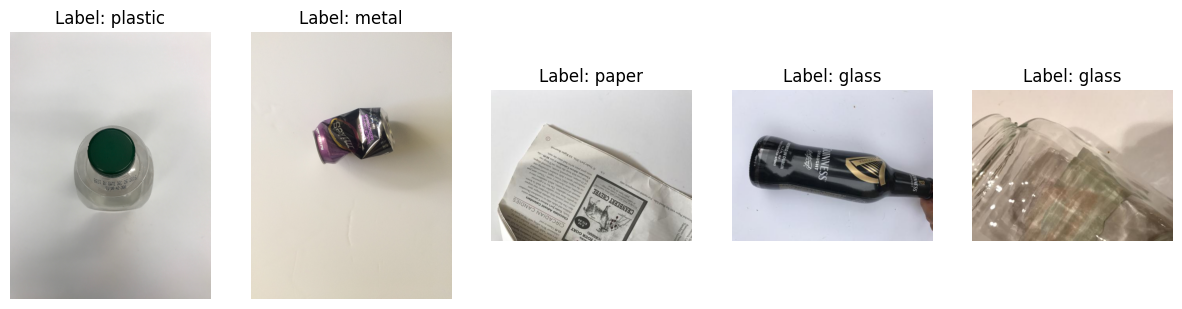

In [ ]:
def display_random_images(dataset, num_images=5):
    label_mapping = dataset.features["label"].int2str

    random_indices = random.sample(range(len(dataset)), num_images)
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(random_indices):
        example = dataset[idx]
        img = example["image"]
        label = example["label"]
        label_name = label_mapping(label)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label_name}")
        plt.axis("off")
    plt.show()

# Display random images from the training set
display_random_images(dataset["train"], num_images=5)

Average Width: 1943.37
Average Height: 1935.83
Max Width: 4032, Min Width: 512
Max Height: 4032, Min Height: 384


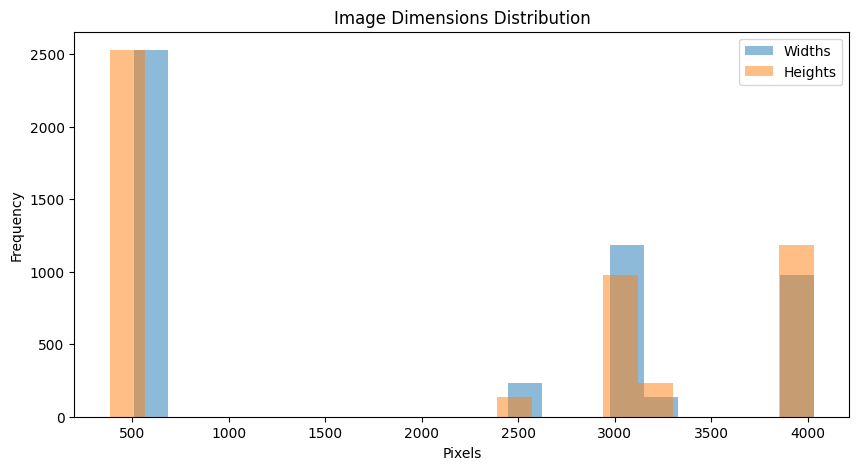

In [ ]:
def analyze_image_sizes(dataset):
    widths, heights = [], []
    for example in dataset:
        img = example["image"]
        widths.append(img.width)
        heights.append(img.height)

    # Calculate and display statistics
    print(f"Average Width: {sum(widths) / len(widths):.2f}")
    print(f"Average Height: {sum(heights) / len(heights):.2f}")
    print(f"Max Width: {max(widths)}, Min Width: {min(widths)}")
    print(f"Max Height: {max(heights)}, Min Height: {min(heights)}")

    # Plot histograms of widths and heights
    plt.figure(figsize=(10, 5))
    plt.hist(widths, bins=20, alpha=0.5, label="Widths")
    plt.hist(heights, bins=20, alpha=0.5, label="Heights")
    plt.legend()
    plt.title("Image Dimensions Distribution")
    plt.xlabel("Pixels")
    plt.ylabel("Frequency")
    plt.show()

# Analyze dimensions of training images
analyze_image_sizes(dataset["train"])

As we can see here, the sizes of the images are not uniform, so we will need to resize them later during the preprocess step

Average R Mean: 170.36
Average G Mean: 160.60
Average B Mean: 148.79


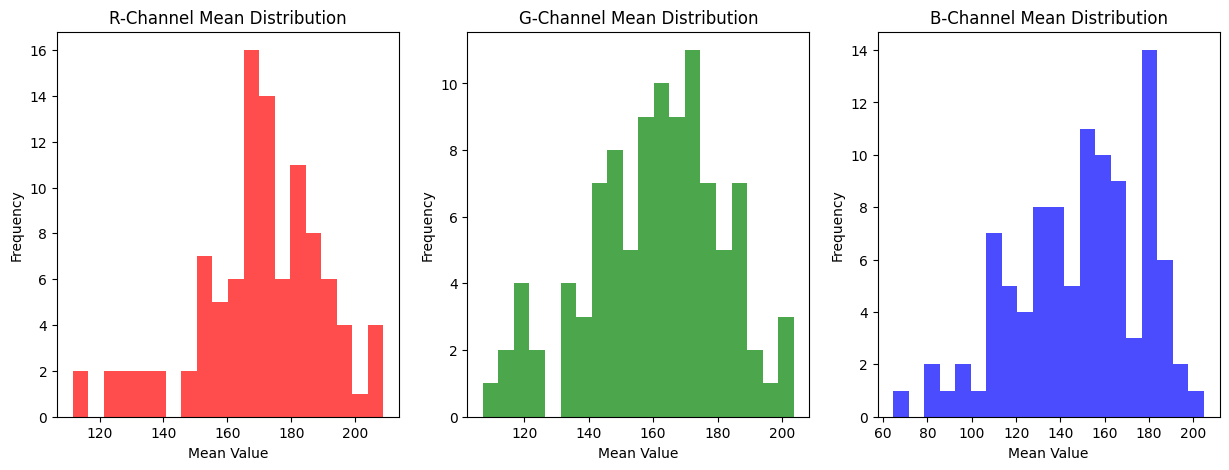

In [ ]:
def analyze_image_channels(dataset, num_samples=100):
    channel_means = {"R": [], "G": [], "B": []}
    sample_indices = random.sample(range(len(dataset)), num_samples)

    for idx in sample_indices:
        img = np.array(dataset[idx]["image"])
        channel_means["R"].append(np.mean(img[:, :, 0]))
        channel_means["G"].append(np.mean(img[:, :, 1]))
        channel_means["B"].append(np.mean(img[:, :, 2]))

    # Calculate global mean for each channel
    global_means = {channel: np.mean(means) for channel, means in channel_means.items()}
    print(f"Average R Mean: {global_means['R']:.2f}")
    print(f"Average G Mean: {global_means['G']:.2f}")
    print(f"Average B Mean: {global_means['B']:.2f}")

    # Plot histograms for each channel
    plt.figure(figsize=(15, 5))
    for i, (channel, means) in enumerate(channel_means.items()):
        plt.subplot(1, 3, i + 1)
        plt.hist(means, bins=20, color=channel.lower(), alpha=0.7)
        plt.title(f"{channel}-Channel Mean Distribution")
        plt.xlabel("Mean Value")
        plt.ylabel("Frequency")
    plt.show()

# Analyze RGB channels in training images
analyze_image_channels(dataset["train"])

Based on the RGB channel analysis, the R-channel average is 170.36, the G-channel average is 160.60, and the B-channel average is 148.79. The distributions are relatively centered and smooth, which means the dataset has well-balanced lighting and color exposure. The RGB values show slight variations but nothing extreme, meaning the dataset’s overall color characteristics are consistent.

Class Distribution:
Class 0: 806 images
Class 1: 1002 images
Class 2: 820 images
Class 3: 1188 images
Class 4: 964 images
Class 5: 274 images


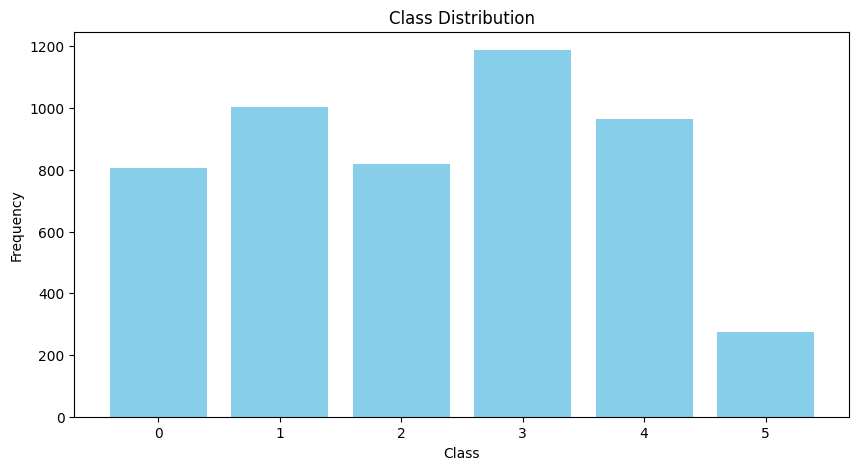

In [ ]:
def plot_class_distribution(dataset):
    labels = dataset["label"]
    label_counts = Counter(labels)

    # Display class frequencies
    print("Class Distribution:")
    for label, count in label_counts.items():
        print(f"Class {label}: {count} images")

    # Plot class distribution
    plt.figure(figsize=(10, 5))
    plt.bar(label_counts.keys(), label_counts.values(), color="skyblue")
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.show()

# Plot class distribution for training set
plot_class_distribution(dataset["train"])

Looking at the class distribution, we’ve got a pretty even spread across the first five classes: cardboard, glass, metal, paper, and plastic. Sure, Class 5 ("trash") has only 274 images, making it the underdog here, but it’s kind of the "miscellaneous" drawer of this dataset, a catch-all for stuff that doesn’t fit the neat categories. And honestly? That’s totally fine.

Why? Because this "trash" class isn’t the core focus of the model. Its role as a general catch-all category does not require strict balancing, as its lower representation aligns with its purpose, to classify items that fall outside the main trash materials. The primary focus remains on accurately identifying the core trash materials

That said, after this step, it’s essential to validate the contents of the "trash" class in the dataset to ensure it aligns with its intended purpose.

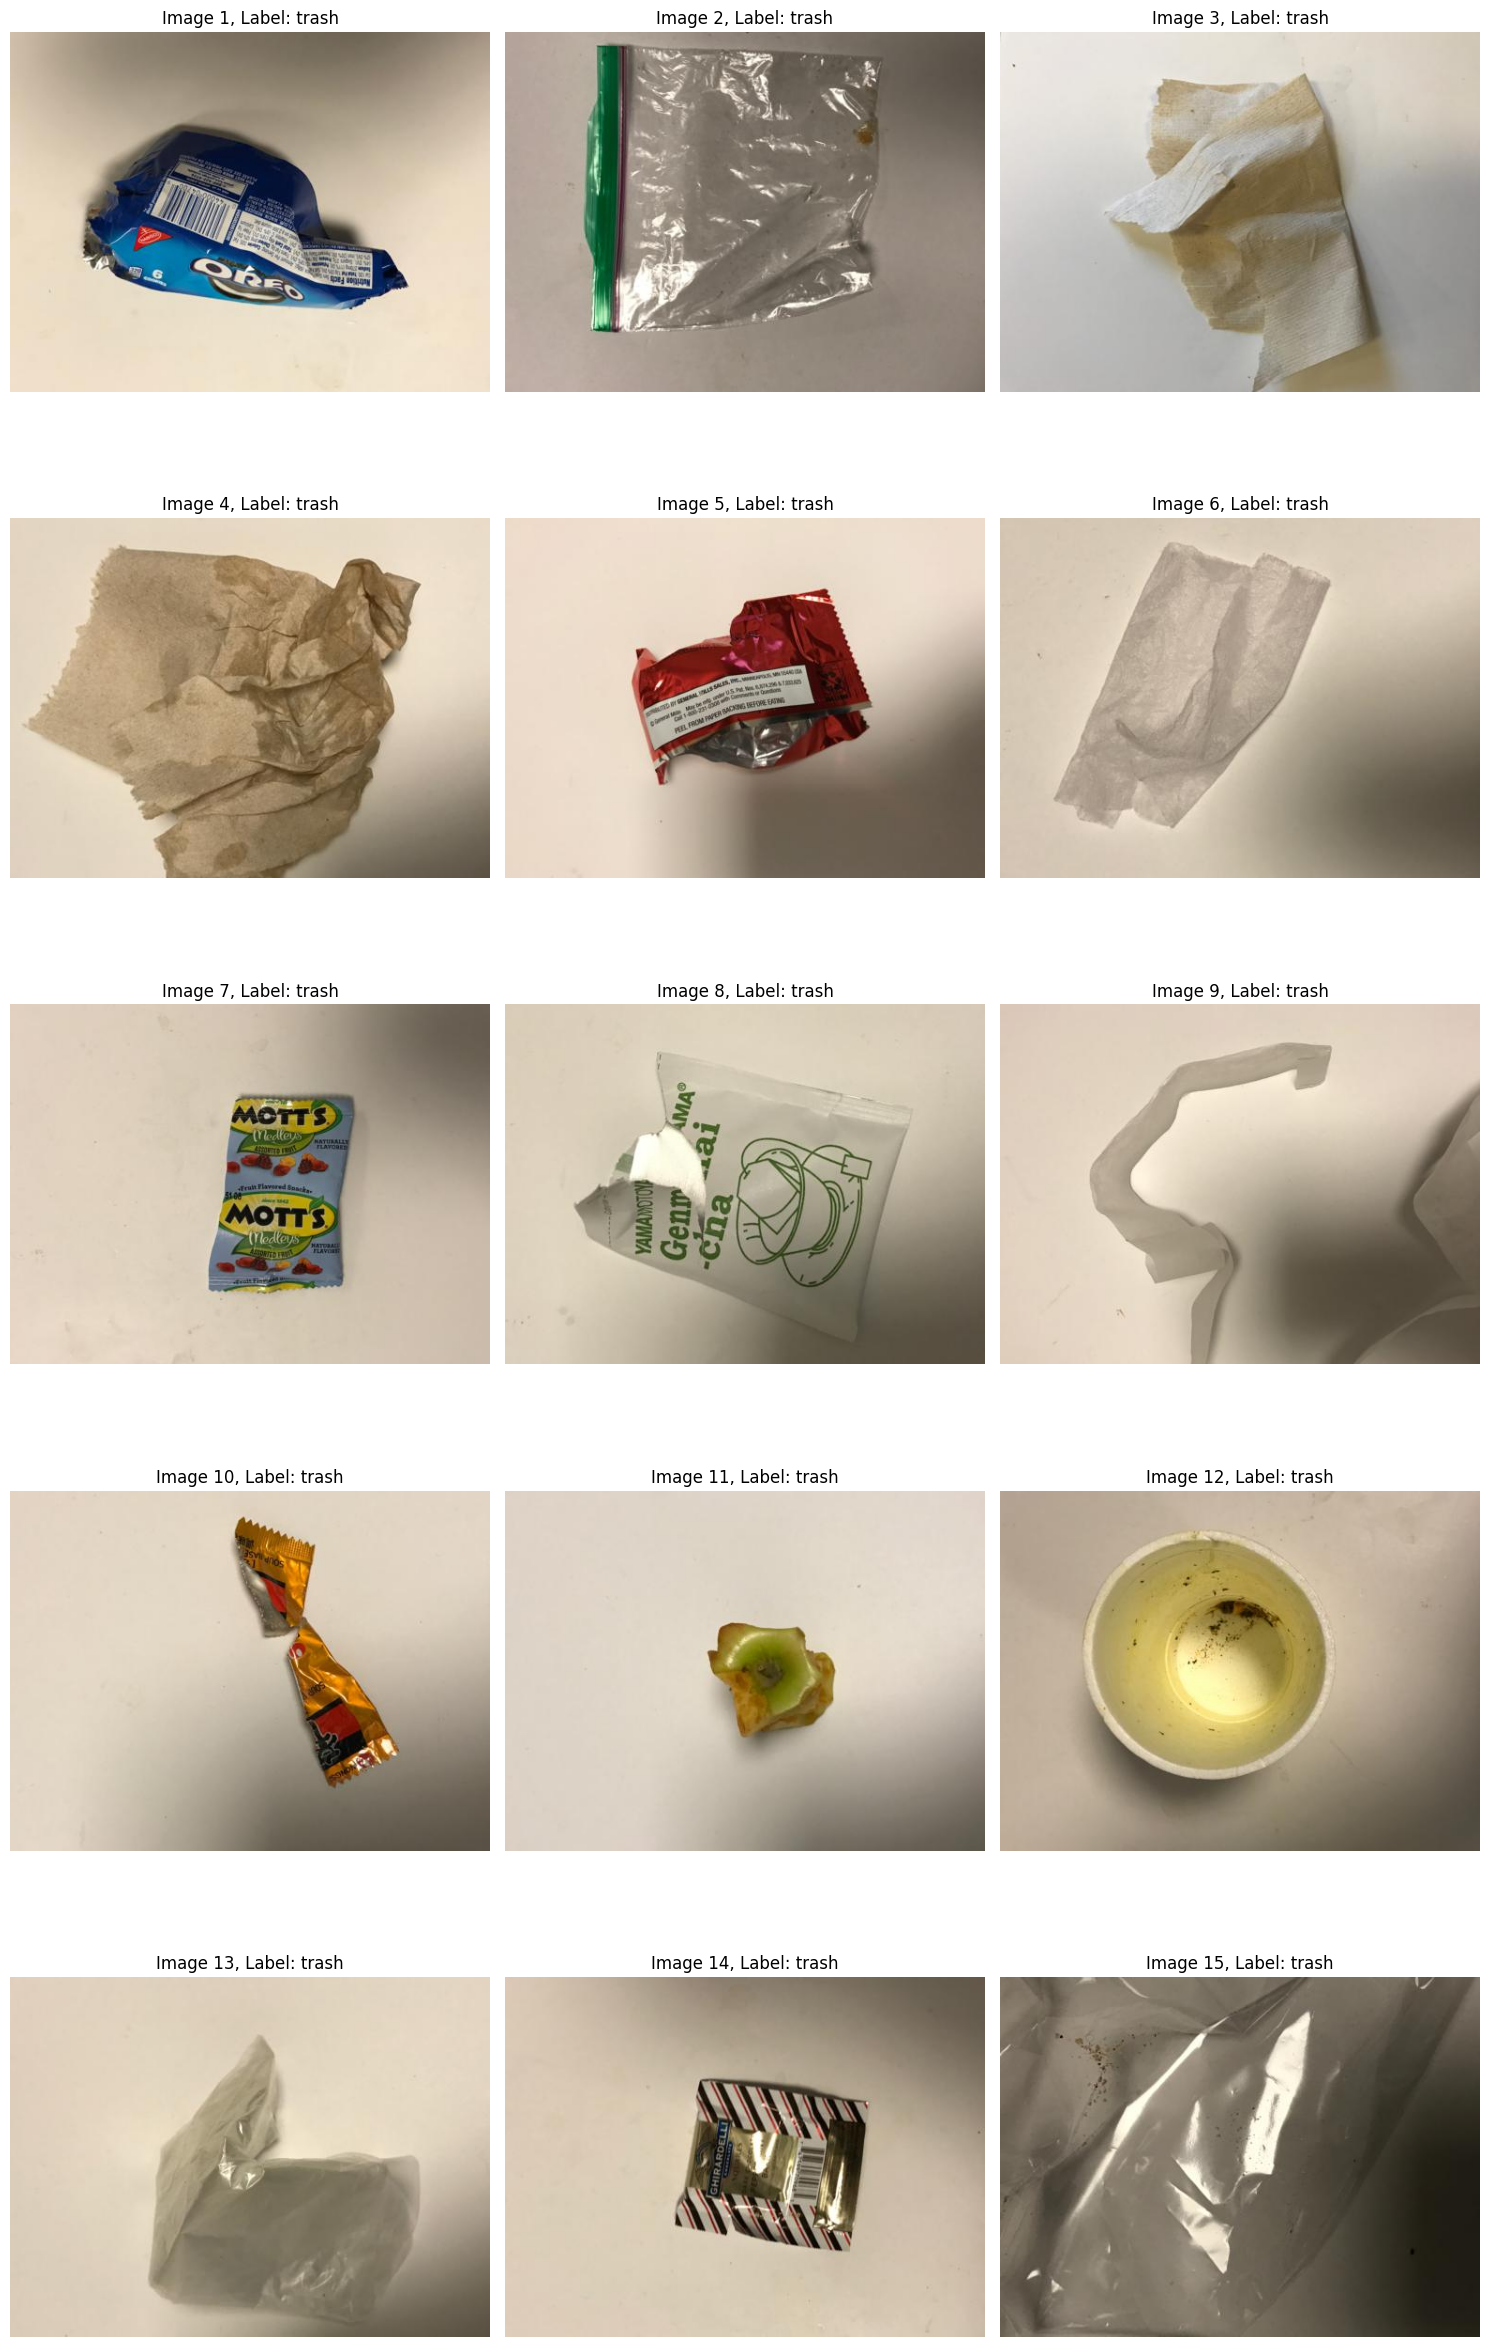

In [ ]:
def display_class_images(dataset, class_label=5, num_images=15):
    label_mapping = dataset.features["label"].int2str

    target_indices = []
    threshold = num_images * 3

    for idx in range(len(dataset) - 1, -1, -1):
        if dataset[idx]["label"] == class_label:
            target_indices.append(idx)
        if len(target_indices) >= threshold:
            break

    if len(target_indices) < num_images:
        print("Warning: Not enough images found for the specified class.")
        num_images = len(target_indices)

    random_indices = sample(target_indices, num_images)

    cols = 3
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(5 * cols, 5 * rows))

    for i, idx in enumerate(random_indices):
        example = dataset[idx]
        img = example["image"]
        label = example["label"]
        label_name = label_mapping(label)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}, Label: {label_name}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Display random images from Class 5 ("trash") in the training set
display_class_images(dataset["train"], class_label=5, num_images=15)

As we can see, the "trash" class appears to be a combination of several sub-classes that might not have been properly categorized yet. For example, images 1, 2, 5, 7, 8, 10, 13, 14, and 15 are categorized as "plastic," while images 3, 4, 6, and 9 belong to the "paper" class. Image 11 represents organic waste, and image 12 is actually "styrofoam," which could be categorized as plastic. This mixed categorization is problematic for the model, as some of the classes are ambiguous and misleading. Therefore, it would be better to remove the "trash" class from the dataset to improve classification accuracy.

In [ ]:
# sort label to make filtering faster
dataset = dataset.sort("label")

In [ ]:
labels = dataset["train"]["label"]
class_counts = Counter(labels)
print(class_counts)

Counter({3: 1188, 1: 1002, 4: 964, 2: 820, 0: 806, 5: 274})


In [ ]:
# Remove images with class label == 5 ("trash")
def remove_class_5(dataset_split):
    indices_to_keep = []
    for idx in range(len(dataset_split) - 1, -1, -1):
        if dataset_split[idx]["label"] == 5:
            continue
        indices_to_keep = list(range(idx + 1))
        break
    return dataset_split.select(indices_to_keep)

Remove class 5 ("trash")

In [ ]:
dataset["train"] = remove_class_5(dataset["train"])

In [ ]:
# Filtered Dataset
labels = dataset["train"]["label"]
class_counts = Counter(labels)
print(class_counts)

Counter({3: 1188, 1: 1002, 4: 964, 2: 820, 0: 806})


### Dataset Preprocessing

Here

Split the dataset into 70%, 15%, and 15% for training, validation, and testing. First, divide the dataset into 70% for training and 30% for validation and testing combined. Then, split the 30% portion evenly into 15% validation and 15% testing. This ensures an equitable distribution between validation and testing, allowing for consistent model evaluation

In [ ]:
# Split dataset into train (70%), validation (15%), and test (15%)
train_test_valid_split = dataset["train"].train_test_split(test_size=0.3, seed=42)
validation_test_split = train_test_valid_split["test"].train_test_split(test_size=0.5, seed=42)

# Assign to respective splits
dataset["train"] = train_test_valid_split["train"]
dataset["validation"] = validation_test_split["train"]
dataset["test"] = validation_test_split["test"]

print(f"Train Dataset: {len(dataset['train'])} samples")
print(f"Validation Dataset: {len(dataset['validation'])} samples")
print(f"Test Dataset: {len(dataset['test'])} samples")

Train Dataset: 3346 samples
Validation Dataset: 717 samples
Test Dataset: 717 samples


Although the lighting and color distributions in the dataset are relatively smooth, preprocessing and data augmentation remain essential for building an effective deep learning model. First, resizing all images to a uniform size (e.g., 224x224) addresses variability in dimensions and ensures compatibility with the model. While resizing may lead to some loss of detail in very small images, using larger image sizes can significantly slow down training. Since most models in research papers are typically trained on image sizes ranging from 128 to 512, resizing to 224x224 is a quiet a balance choice, though I can research further the effect of using different sizes. Data augmentation techniques, such as random horizontal flips, small rotations, and color jittering, introduce variability to the training data by simulating changes in orientation, lighting, and appearance. These augmentations enhance the model’s ability to generalize and handle real-world variations. However, excessive augmentation can introduce noise or unrealistic variations, which is why the augmentations are applied with a probability of 0.5, and color jittering is limited to adjustments up to 0.2. Finally, normalization scales pixel values to a range of [-1, 1], which stabilizes gradient descent and improves training efficiency. For validation and testing, only resizing and normalization are applied to ensure consistent evaluation without introducing artificial variability.

In [ ]:
# Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 (since image sizes are not uniform)

    # Data augmentation to improve model generalization and robustness
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    ], p=0.5),

    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1], range suitable for the model (in this case std deviation of 1)
])


val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

### Model

In the bottleneck layer of the model, an attention mechanism is used to enhance feature extraction by focusing on the most important features. This mechanism consists of two types of attention: channel attention and spatial attention. The channel attention module prioritizes important feature channels, while the spatial attention module identifies significant spatial regions. This structure is computationally efficient due to its use of pooling operations and simple transformations.

The channel attention module utilizes adaptive max pooling and average pooling along the spatial dimensions to compress the feature map into a 1×1 representation for each channel. These pooled representations are then passed through fully connected (FC) layers to compute the attention weights for each channel, which are subsequently combined and applied using a sigmoid function. The resulting attention weights are multiplied with the original feature map to emphasize the most significant channels.

The spatial attention module applies max pooling and average pooling along the channel axis to compress the feature map into two spatial feature maps. These are concatenated along the channel dimension, forming a two-channel representation that highlights key spatial regions. A convolutional layer with a kernel size of 7 is then applied, followed by a sigmoid activation to generate spatial attention weights. These weights are multiplied with the feature map to adjust the importance of the spatial.

The combined attention processes the feature map sequentially,  the channel attention is applied first, adjusting the importance of feature channels, and its output is passed to the spatial attention module to refine spatial feature importance. The final output is the sum of the attention-modulated feature map and the original input, maintaining residual connections to preserve the original information flow.

In [ ]:
class ChannelAttentionModule(nn.Module):
    """
    Module to apply channel-wise attention by focusing on important channels in the input feature map.
    """
    def __init__(self, channels, r):
        super(ChannelAttentionModule, self).__init__()
        reduced_channels = channels // r
        self.linear = nn.Sequential(
            nn.Linear(channels, reduced_channels),
            nn.ReLU(inplace=True),
            nn.Linear(reduced_channels, channels),
        )
    def forward(self, x):
        b, c, _, _ = x.size()

        # Global pooling to summarize channel importance
        max_pool = F.adaptive_max_pool2d(x, 1).view(b, c)
        avg_pool = F.adaptive_avg_pool2d(x, 1).view(b, c)

        # Apply fc to compute attention
        attention = self.linear(max_pool) + self.linear(avg_pool)
        attention = torch.sigmoid(attention).view(b, c, 1, 1)

        return x * attention

class SpatialAttentionModule(nn.Module):
    """
    Module to apply spatial attention by focusing on important spatial regions in the feature map.
    """
    def __init__(self, bias=False):
        super(SpatialAttentionModule, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, stride=1, padding=3, bias=bias)
    def forward(self, x):

        # Compute max pooling and average pooling along the channel axis
        max_pool, _ = torch.max(x, dim=1, keepdim=True) # Max pooling (B, 1, H, W)
        avg_pool = torch.mean(x, dim=1, keepdim=True) # Average pooling (B, 1, H, W)

        # Concatenate along the channel axis to form a 2-channel tensor
        concat = torch.cat((max_pool, avg_pool), dim=1)

        # Apply convolution and sigmoid to compute attention map
        attention = torch.sigmoid(self.conv(concat))

        return x * attention

class AttentionModule(nn.Module):
    """
    Combined attention module that applies both channel and spatial attention.
    """
    def __init__(self, channels, r=8, bias=False):
        super(AttentionModule, self).__init__()
        self.channel_attention = ChannelAttentionModule(channels, r)
        self.spatial_attention = SpatialAttentionModule(bias)

    def forward(self, x):
        residual = x
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x + residual

The LightModule is designed as a lightweight convolutional module to improve efficiency and reduce redundancy in feature extraction, inspired by concepts from the GhostNet paper presented at CVPR. This module incorporates a depthwise convolution (from MobileNet) that processes each channel independently, significantly reducing parameters compared to standard convolutions. Unlike MobileNet's depthwise separable convolution, the LightModule combines a traditional convolution with a depthwise convolution to extract features more comprehensively.

The decision to use depthwise convolution instead of additional standard convolutions is based on findings in the GhostNet paper, which highlight that many feature maps generated by traditional convolutions are redundant or similar. By using depthwise convolution to expand the feature space, the module effectively reduces redundancy.

The ReLU activation function is used to mitigate the vanishing gradient problem, as its derivative remains constant for positive values. While alternatives like Leaky ReLU or Hard Swish could address specific issues such as negative slope handling or smoother gradients, ReLU was chosen due to its popularity being used in many papers. Though, it is better to try those alternatives, given constraints on time and computational resources, experimenting with alternative activations was deferred.


In [ ]:
class LightModule(nn.Module):
    """
    A lightweight convolutional module that generates efficient feature maps by combining
    a traditional convolution and a depthwise convolution to expand the feature space.
    """
    def __init__(self, in_channels, out_channels, kernel_size=1, ratio=2, stride=1, dw_size=3, relu=True):
        super(LightModule, self).__init__()
        self.out_channels = out_channels

        # Calculate the number of channels for the two convolution stages
        init_channels = math.ceil(out_channels / ratio)
        new_channels = out_channels - init_channels

        self.traditional_conv = nn.Sequential(
            nn.Conv2d(in_channels, init_channels, kernel_size, stride, padding=kernel_size // 2, bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True) if relu else nn.Identity()
        )

        # Depthwise convolution to generate additional feature maps
        self.dw_conv = nn.Sequential(
            nn.Conv2d(init_channels, new_channels, kernel_size=dw_size, stride=1, padding=dw_size // 2, groups=init_channels, bias=False),
            nn.BatchNorm2d(new_channels),
            nn.ReLU(inplace=True) if relu else nn.Identity()
        )

    def forward(self, x):
        x1 = self.traditional_conv(x)
        x2 = self.dw_conv(x1)
        out = torch.cat([x1, x2], dim=1)

        return out[:, :self.out_channels, :, :]

The LightBottleneck module is a lightweight and efficient architecture inspired by ResNet's basic residual block. It consists two stacked LightModules, the first expands the number of channels to a higher-dimensional space (hidden channels), and the second reduces the channels to match the size of the shortcut path.

An attention module, as introduced earlier, is optionally included between the two LightModules based on the value of r. This module enhances feature refinement by selectively important spatial and channel features.

The shortcut path preserves input information and improves gradient flow, mitigating the vanishing gradient problem. It is particularly effective when the input and output channels differ or when the stride is greater than 1, ensuring that critical information is retained and propagated throughout the network.

In [ ]:
class LightBottleneck(nn.Module):
    """
    Lightweight bottleneck module with optional attention.
    """
    def __init__(self, in_channels, mid_channels, out_channels, dw_kernel_size=3, stride=1, act_layer=nn.ReLU, r=8):
        super(LightBottleneck, self).__init__()
        self.stride = stride

        # First LightModule
        self.light1 = LightModule(in_channels, mid_channels, relu=True)

        # Optional depthwise convolution for stride > 1
        self.dw_conv = nn.Sequential(
            nn.Conv2d(mid_channels, mid_channels, dw_kernel_size, stride=stride,
                      padding=(dw_kernel_size - 1) // 2, groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels)
        ) if stride > 1 else nn.Identity()

        # Optional attention module
        self.attention = AttentionModule(mid_channels, r=r) if r > 1 else nn.Identity()

        # Second LightModule
        self.light2 = LightModule(mid_channels, out_channels, relu=False)

        # Shortcut connection
        self.shortcut = (
            nn.Sequential(
                nn.Conv2d(in_channels, in_channels, dw_kernel_size, stride=stride,
                          padding=(dw_kernel_size - 1) // 2, groups=in_channels, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_channels),
            )
            if in_channels != out_channels or stride != 1
            else nn.Identity()
        )

    def forward(self, x):
        residual = x

        x = self.light1(x)
        x = self.dw_conv(x)
        x = self.attention(x)
        x = self.light2(x)

        return x + self.shortcut(residual)

In [ ]:
def _make_divisible(v, divisor, min_value=None):
    min_value = min_value or divisor
    half_divisor = divisor / 2

    new_v = max(min_value, int(v + half_divisor) - (int(v + half_divisor) % divisor))

    # to avoid significant reduction in value
    if new_v < (v * 0.9):
        new_v += divisor
    return new_v

The stem layer in the TrashNet architecture is a critical initial step designed to efficiently process raw input images and extract fundamental features before they are passed to deeper layers. It uses a 3x3 convolution with a stride of 2, which not only captures low-level patterns like edges and textures but also reduces the spatial resolution of the input. The use of a 3x3 kernel is a common choice for its balance between capturing local details and computational efficiency. Meanwhile the configuration is similar to the MobileNetv3 configuration.

In [ ]:
class TrashNet(nn.Module):
    """
    TrashNet: A lightweight convolutional neural network designed with flexible
    bottleneck blocks and an efficient attention mechanism.
    """
    def __init__(self, cfgs, num_classes=1000, width=1.0, dropout=0.2):
        super(TrashNet, self).__init__()
        self.cfgs = cfgs
        self.dropout = dropout

        # Initial stem layer
        out_channels = _make_divisible(16 * width, 4)
        self.conv_stem = nn.Conv2d(3, out_channels, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.act1 = nn.ReLU(inplace=True)
        in_channels = out_channels

        # Build the blocks
        stages = []
        block = LightBottleneck
        for cfg in self.cfgs:
            layers = []
            for k, exp_size, c, r, s in cfg:
                out_channels = _make_divisible(c * width, 4)
                hidden_channels = _make_divisible(exp_size * width, 4)
                layers.append(
                    block(in_channels, hidden_channels, out_channels, dw_kernel_size=k, stride=s, r=r)
                )
                in_channels = out_channels
            stages.append(nn.Sequential(*layers))

        # Final convolution stage
        out_channels = _make_divisible(exp_size * width, 4)
        stages.append(
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )
        )
        in_channels = out_channels
        self.blocks = nn.Sequential(*stages)

        # Classification head
        out_channels = 1280
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.conv_head = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=True)
        self.act2 = nn.ReLU(inplace=True)
        self.classifier = nn.Linear(out_channels, num_classes)

    def forward(self, x):

        # Stem
        x = self.conv_stem(x)
        x = self.bn1(x)
        x = self.act1(x)

        # Bottleneck blocks
        x = self.blocks(x)

        # Classification head
        x = self.global_pool(x)
        x = self.conv_head(x)
        x = self.act2(x)
        x = x.view(x.size(0), -1) # Flatten
        if self.dropout > 0.0:
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.classifier(x)
        return x

In [ ]:
def trashnet(**kwargs):
    """
    Constructs a TrashNet model
    """
    cfgs = [
        # Configuration format: [kernel_size, expansion_factor, output_channels, reduction_ratio, stride]

        # stage1
        [[3, 16, 16, 0, 1]],

        # stage2
        [[3, 48, 24, 0, 2]],
        [[3, 72, 24, 0, 1]],

        # stage3
        [[5, 72, 40, 8, 2]],
        [[5, 120, 40, 8, 1]],

        # stage4
        [[3, 240, 80, 0, 2]],
        [
            [3, 200, 80, 0, 1],
            [3, 184, 80, 0, 1],
            [3, 184, 80, 0, 1],
            [3, 480, 112, 8, 1],
            [3, 672, 112, 8, 1],
        ],

        # stage5
        [[5, 672, 160, 8, 2]],
        [
            [5, 960, 160, 0, 1],
            [5, 960, 160, 8, 1],
            [5, 960, 160, 0, 1],
            [5, 960, 160, 8, 1],
        ],
    ]
    return TrashNet(cfgs, **kwargs)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Get the label distribution
labels = dataset["train"]["label"]  # Extract labels from training set
class_counts = Counter(labels)
num_classes = len(class_counts)

In [ ]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())

model_count = trashnet(num_classes=num_classes).to(device)

params = count_params(model_count)
print(f"Total Parameters: {params / 1e6:.2f} Million")

Total Parameters: 3.16 Million


The parameter size is 3.16 million which is quiet small

### Dataloader

In [ ]:
# data configurations
train_batch_size = 64
val_batch_size = 32
test_batch_size = 32
num_workers = 2

The batch sizes of 64 for training and 32 for validation and testing are chosen as reasonable defaults for balancing memory constraints. Though in best practice, these batch sizes, however, should be tested across different values to determine the optimal setup for specific hardware and dataset characteristics, as performance and convergence can vary significantly based on this parameter. But due to time constraint I was unable to test all. The num_workers parameter is set to 2, following Colab's best practices according to its hardware. While this works well in many cases, testing with varying num_workers values is recommended to achieve the best data loading performance on different platforms or hardware setups. The transformations defined earlier, including data augmentation for training and  resizing and normalization for validation and testing, are integrated into the data loaders.

In [ ]:
# Define a function to convert Hugging Face dataset into PyTorch DataLoader
def dataset_to_dataloader(dataset, transform, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True):
    class HuggingFaceDataset(Dataset):
        def __init__(self, dataset, transform):
            self.dataset = dataset
            self.transform = transform

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            item = self.dataset[idx]
            image = item["image"]
            label = item["label"]
            image = self.transform(image)
            return image, label

    return DataLoader(
        HuggingFaceDataset(dataset, transform),
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=True,
        prefetch_factor=4,
    )

# Create DataLoaders
train_loader = dataset_to_dataloader(
    dataset["train"],
    train_transform,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

val_loader = dataset_to_dataloader(
    dataset["validation"],
    val_test_transform,
    batch_size=val_batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = dataset_to_dataloader(
    dataset["test"],
    val_test_transform,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

### Train

In [ ]:
# Compute class weights
class_weights = torch.tensor(
    [1.0 / class_counts.get(i, 1e-6) for i in range(num_classes)],
    dtype=torch.float
)
class_weights /= class_weights.sum()  # Normalize weights
print(f"Class Weights: {class_weights}")

Class Weights: tensor([0.2294, 0.1808, 0.2347, 0.1555, 0.1996])


The dataset, while relatively balanced, exhibits some variation in class distribution, with a standard deviation of approximately 138 images across classes. To address this little imbalance, class weights are calculated and applied to the cross-entropy loss function. These weights are inversely proportional to the class frequencies and normalized to ensure a fair contribution from each class during training. By doing so, the model avoids biasing predictions toward overrepresented classes and encourages it to learn features for minority classes, improving generalization across all categories. This approach is simple to implement and computationally efficient, making it a practical solution for moderate class imbalances. However, its effectiveness depends on accurate class counts, and for highly imbalanced datasets, additional techniques such as oversampling or data augmentation may be required. But in this case I do not need oversampling

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

Early stopping is an effective strategy for time-limited and hardware constrained scenarios like in this case. It monitors validation loss during training and stops when no significant improvement is observed for a specified patience window (set to 5 epochs in this case). This approach ensures that training halts once the model has effectively converged, saving valuable time and computational resources. Additionally, the best model is saved, avoiding unnecessary overfitting or wasted effort on further epochs. While it is efficient and resource-friendly, it may prematurely stop training if not carefully tuned.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001, verbose=True, path="best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        """Saves the model when validation loss improves."""
        if self.verbose:
            print(f"Validation loss improved. Saving model to {self.path}")
        torch.save(model.state_dict(), self.path)


The chosen metrics,accuracy, macro-averaged, and micro-averaged precision, recall, and F1-score provide a comprehensive evaluation for multi-class classification tasks. Accuracy offers a quick overview of overall performance, and since this dataset is relatively balanced, it can serve as a reliable reference. Macro-averaged metrics ensure fair evaluation by treating all classes equally, calculating precision and recall as the arithmetic mean of individual class scores. Meanwhile, micro-averaged metrics aggregate results across all samples, with precision and recall derived from the overall true positives (TPs), true negatives (TNs), false positives (FPs), and false negatives (FNs) of the model. The macro-averaged F1-score is similarly calculated as the arithmetic mean of individual class F1-scores. By combining these metrics with per-class evaluations, this approach provides a detailed understanding of the model's performance, addressing both class-specific and overall effectiveness.

In [ ]:
def compute_metrics(y_true, y_pred, num_classes):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Ensure valid inputs
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length")

    # Accuracy
    accuracy = np.mean(y_true == y_pred)

    # Precision, Recall, and F1 score (per class)
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)

    for cls in range(num_classes):
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))

        precision[cls] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[cls] = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1[cls] = (
            2 * precision[cls] * recall[cls] / (precision[cls] + recall[cls])
            if (precision[cls] + recall[cls]) > 0
            else 0
        )

    # Macro-Averaged Metrics
    precision_macro = np.mean(precision)
    recall_macro = np.mean(recall)
    f1_macro = np.mean(f1)

    # Micro-Averaged Metrics (treat as binary classification across all classes)
    tp_micro = np.sum((y_true == y_pred))
    fp_micro = np.sum((y_pred != y_true) & (y_pred != -1))
    fn_micro = np.sum((y_true != y_pred) & (y_true != -1))

    precision_micro = tp_micro / (tp_micro + fp_micro) if (tp_micro + fp_micro) > 0 else 0
    recall_micro = tp_micro / (tp_micro + fn_micro) if (tp_micro + fn_micro) > 0 else 0
    f1_micro = (
        2 * precision_micro * recall_micro / (precision_micro + recall_micro)
        if (precision_micro + recall_micro) > 0
        else 0
    )

    return {
        "accuracy": accuracy,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro,
        "per_class": {
            "precision": precision,
            "recall": recall,
            "f1": f1,
        },
    }

The confusion matrix provides a detailed breakdown of the model's performance by showing the counts of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) for each class. This helps identify specific classes where the model performs well or struggles

In [ ]:
def compute_confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        if 0 <= t < num_classes and 0 <= p < num_classes:
            cm[t, p] += 1
        else:
            print(f"Warning: Ignoring out-of-range values t={t}, p={p}")
    return cm

In [ ]:
def train_one_epoch(model, train_loader, optimizer, criterion, device, num_classes):
    model.train()
    scaler = torch.amp.GradScaler(device)
    total_loss = 0.0
    accumulation_steps = 4
    y_true, y_pred = [], []

    optimizer.zero_grad()

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels) / accumulation_steps

        # Backward pass
        scaler.scale(loss).backward()

        # Collect predictions and labels
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        # Cumulative loss
        total_loss += loss.item()

        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        # Compute metrics for every 10 batch
        if (batch_idx + 1) % 10 == 0:
            batch_metrics = compute_metrics(y_true[-len(labels):], preds.cpu().numpy(), num_classes)
            print(f"[Train Batch {batch_idx + 1}/{len(train_loader)}] "
                  f"Loss: {loss.item():.4f} | "
                  f"Accuracy: {batch_metrics['accuracy']:.4f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Compute epoch-level metrics
    metrics = compute_metrics(y_true, y_pred, num_classes)
    confusion_matrix = compute_confusion_matrix(y_true, y_pred, num_classes)

    # Log metrics to wandb
    wandb.log({
        "train_loss": total_loss / len(train_loader),
        "train_accuracy": metrics["accuracy"],
        "train_precision_macro": metrics["precision_macro"],
        "train_recall_macro": metrics["recall_macro"],
        "train_f1_macro": metrics["f1_macro"],
        "train_precision_micro": metrics["precision_micro"],
        "train_recall_micro": metrics["recall_micro"],
        "train_f1_micro": metrics["f1_micro"],
        "train_confusion_matrix": wandb.plot.confusion_matrix(
            y_true=np.array(y_true), preds=np.array(y_pred), class_names=[str(i) for i in range(num_classes)]
        ),
    })

    return total_loss / len(train_loader), metrics

In [ ]:
def validate_one_epoch(model, val_loader, criterion, device, num_classes):
    model.eval()
    total_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Collect predictions and labels
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            # Cumulative loss
            total_loss += loss.item()

            # Compute metrics for every 10 batch
            if (batch_idx + 1) % 10 == 0:
                batch_metrics = compute_metrics(y_true[-len(labels):], preds.cpu().numpy(), num_classes)
                print(f"[Val Batch {batch_idx + 1}/{len(val_loader)}] "
                      f"Loss: {loss.item():.4f} | "
                      f"Accuracy: {batch_metrics['accuracy']:.4f}")

    # Compute epoch-level metrics
    metrics = compute_metrics(y_true, y_pred, num_classes)
    confusion_matrix = compute_confusion_matrix(y_true, y_pred, num_classes)

    # Log metrics to wandb
    wandb.log({
        "val_loss": total_loss / len(val_loader),
        "val_accuracy": metrics["accuracy"],
        "val_precision_macro": metrics["precision_macro"],
        "val_recall_macro": metrics["recall_macro"],
        "val_f1_macro": metrics["f1_macro"],
        "val_precision_micro": metrics["precision_micro"],
        "val_recall_micro": metrics["recall_micro"],
        "val_f1_micro": metrics["f1_micro"],
        "val_confusion_matrix": wandb.plot.confusion_matrix(
            y_true=np.array(y_true), preds=np.array(y_pred), class_names=[str(i) for i in range(num_classes)]
        ),
    })

    return total_loss / len(val_loader), metrics

In [ ]:
def test_model(model, test_loader, device, num_classes):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    metrics = compute_metrics(y_true, y_pred, num_classes)
    confusion_matrix = compute_confusion_matrix(y_true, y_pred, num_classes)
    label_mapping = dataset['test'].features["label"].int2str

    print("\nTest Results:")
    for k, v in metrics.items():
        if not isinstance(v, dict):
            print(f"{k}: {v:.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix)

    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[label_mapping(i) for i in range(num_classes)], yticklabels=[label_mapping(i) for i in range(num_classes)])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return metrics

The best practice is to test these hyperparameters with different values to optimize the model's performance.

In [ ]:
# Training settings
best_val_accuracy = 0.0
early_stopping = EarlyStopping(patience=5, delta=0.001, path="best_trashnet_model.pth")
epoch = 100
lr = 0.001

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="trashnet-classification", config={
    "train_batch_size ": train_batch_size,
    "val_batch_size  ": val_batch_size,
    "epochs": epoch,
    "learning_rate": lr,
    "num_classes": num_classes
})

wandb: Currently logged in as: mgradyn. Use `wandb login --relogin` to force relogin


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = trashnet(num_classes=num_classes).to(device)
torch.backends.cudnn.benchmark = True

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=3, factor=0.5
)

for epoch in range(epoch):
    print(f"\nEpoch {epoch + 1}/100")

    train_loss, train_metrics = train_one_epoch(
        model, train_loader, optimizer, criterion, device, num_classes
    )
    print(
        f"Train Metrics:\n"
        f"Loss: {train_loss:.4f} | "
        f"Accuracy: {train_metrics['accuracy']:.4f} | "
        f"Precision (Macro): {train_metrics['precision_macro']:.4f} | "
        f"Recall (Macro): {train_metrics['recall_macro']:.4f} | "
        f"F1 (Macro): {train_metrics['f1_macro']:.4f} | "
        f"Precision (Micro): {train_metrics['precision_micro']:.4f} | "
        f"Recall (Micro): {train_metrics['recall_micro']:.4f} | "
        f"F1 (Micro): {train_metrics['f1_micro']:.4f}"
    )

    print("\nTrain Per-Class Metrics:")
    for class_idx in range(num_classes):
        print(
            f"Class {class_idx}: "
            f"Precision: {train_metrics['per_class']['precision'][class_idx]:.4f} | "
            f"Recall: {train_metrics['per_class']['recall'][class_idx]:.4f} | "
            f"F1: {train_metrics['per_class']['f1'][class_idx]:.4f}"
        )

    val_loss, val_metrics = validate_one_epoch(
        model, val_loader, criterion, device, num_classes
    )
    print(
        f"\nValidation Metrics:\n"
        f"Loss: {val_loss:.4f} | "
        f"Accuracy: {val_metrics['accuracy']:.4f} | "
        f"Precision (Macro): {val_metrics['precision_macro']:.4f} | "
        f"Recall (Macro): {val_metrics['recall_macro']:.4f} | "
        f"F1 (Macro): {val_metrics['f1_macro']:.4f} | "
        f"Precision (Micro): {val_metrics['precision_micro']:.4f} | "
        f"Recall (Micro): {val_metrics['recall_micro']:.4f} | "
        f"F1 (Micro): {val_metrics['f1_micro']:.4f}"
    )

    # Print per-class metrics for validation
    print("\nValidation Per-Class Metrics:")
    for class_idx in range(num_classes):
        print(
            f"Class {class_idx}: "
            f"Precision: {val_metrics['per_class']['precision'][class_idx]:.4f} | "
            f"Recall: {val_metrics['per_class']['recall'][class_idx]:.4f} | "
            f"F1: {val_metrics['per_class']['f1'][class_idx]:.4f}"
        )

    # Save best model based on validation accuracy
    if val_metrics['accuracy'] > best_val_accuracy:
        best_val_accuracy = val_metrics['accuracy']
        save_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_accuracy': best_val_accuracy,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics
        }
        torch.save(save_dict, "best_trashnet_model.pth")
        print("\nSaved best model.")


    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

    scheduler.step(val_loss)
    torch.cuda.empty_cache()

print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f}")


Epoch 1/100
[Train Batch 10/53] Loss: 0.3726 | Accuracy: 0.2969 | LR: 0.001000
[Train Batch 20/53] Loss: 0.3692 | Accuracy: 0.3281 | LR: 0.001000
[Train Batch 30/53] Loss: 0.2952 | Accuracy: 0.5469 | LR: 0.001000
[Train Batch 40/53] Loss: 0.3124 | Accuracy: 0.5312 | LR: 0.001000
[Train Batch 50/53] Loss: 0.2746 | Accuracy: 0.6250 | LR: 0.001000
Train Metrics:
Loss: 0.3445 | Accuracy: 0.3915 | Precision (Macro): 0.3988 | Recall (Macro): 0.4063 | F1 (Macro): 0.3898 | Precision (Micro): 0.3915 | Recall (Micro): 0.3915 | F1 (Micro): 0.3915

Train Per-Class Metrics:
Class 0: Precision: 0.5055 | Recall: 0.6491 | F1: 0.5684
Class 1: Precision: 0.3338 | Recall: 0.3140 | F1: 0.3236
Class 2: Precision: 0.3078 | Recall: 0.3321 | F1: 0.3195
Class 3: Precision: 0.4964 | Recall: 0.2461 | F1: 0.3291
Class 4: Precision: 0.3504 | Recall: 0.4901 | F1: 0.4087
[Val Batch 10/23] Loss: 1.1374 | Accuracy: 0.5312
[Val Batch 20/23] Loss: 1.4121 | Accuracy: 0.4375

Validation Metrics:
Loss: 1.1841 | Accuracy: 

Training was conducted on a Colab T4 (Free tier), as my trusty GTX 1050 just couldn’t handle the computational demands. With Colab’s limited session times, I managed to squeeze in 27 epochs. Despite these constraints, the model performed admirably on the TrashNet dataset, achieving solid metrics across training and validation phases.

During training, the model achieved a loss of 0.0808 and an accuracy of 88.43%, with macro and micro F1-scores closely aligned at 0.8842 and 0.8843, respectively. The per-class metrics highlighted strong performance, with Class 0 (cardboard) achieving the highest precision and recall, while Class 2 (metal) demonstrated slight difference in precision and recall.

On validation, the model produced an accuracy of 82.57%, maintaining relatively balanced macro and micro F1-scores at 0.8232 and 0.8257. Per-class analysis showed that Class 3 (paper) performed the best with a precision of 94.19% and an F1-score of 91.01%, while Class 1 (glass) struggled slightly, with an F1-score of 73.21%, which also happen with class 4 with F1-socre of 76.34%. This disparity suggests that the model may be slightly overfitting to these classes

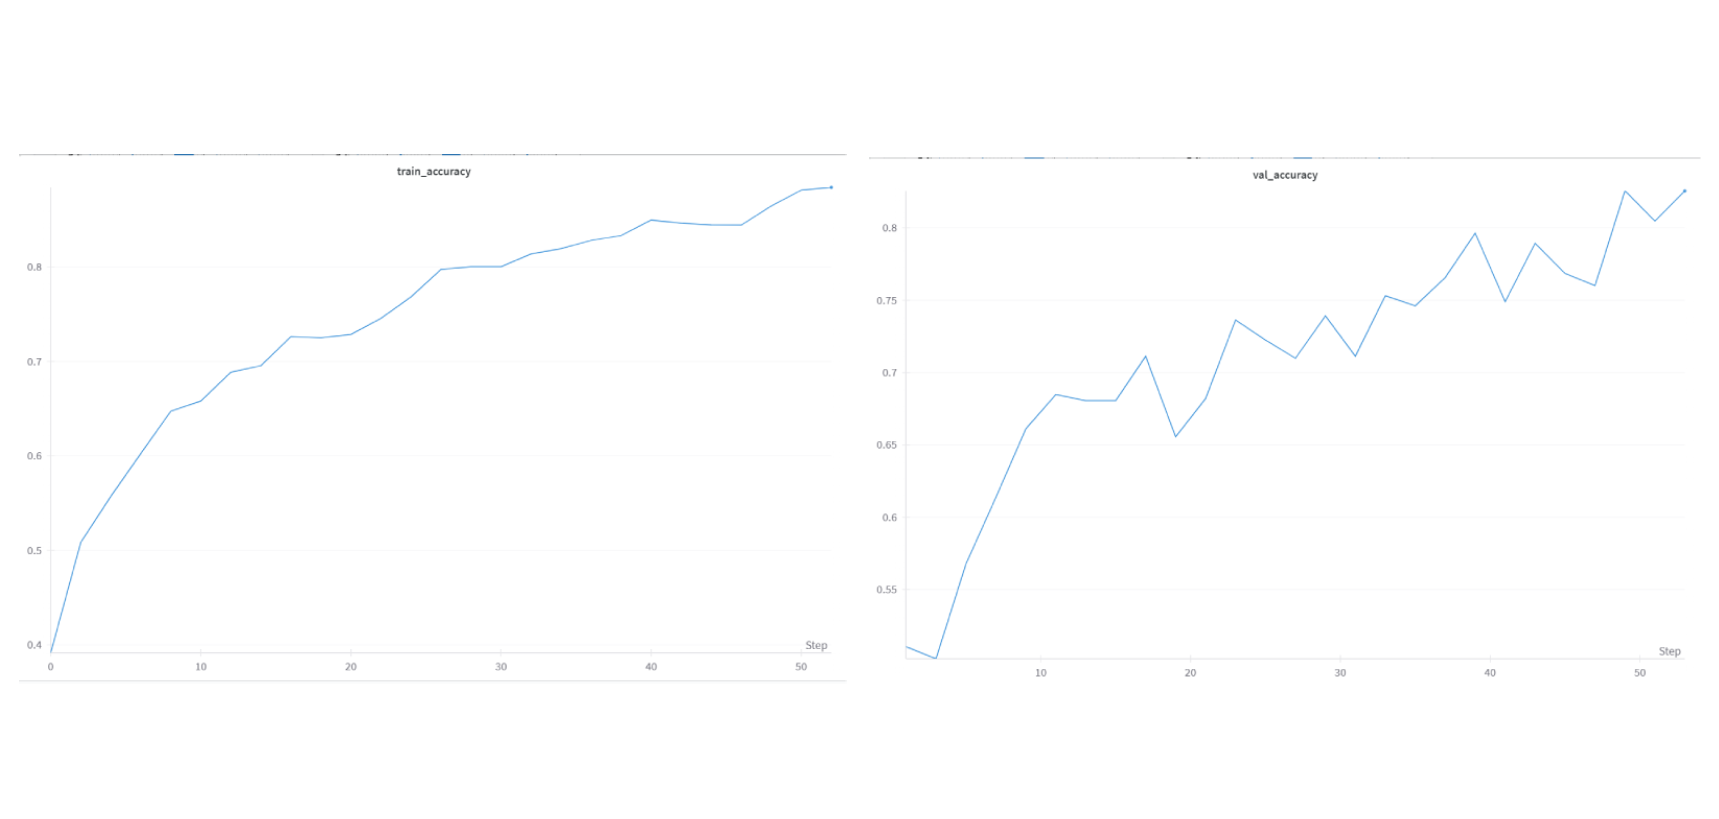

The training and validation accuracy graphs show steady improvement across epochs, with training accuracy shows a smooth upward trend. By the final epochs, training accuracy approaches a plateau near 0.88, suggesting that the model is close to convergence. Validation accuracy, while showing an overall upward trend, fluctuates slightly, which may be due to variability in the validation set or minor overfitting during certain stages of training. Despite these fluctuations, the general upward trend suggests that the model is effectively learning meaningful features and is on track to achieve a stable performance rather than being trapped in a local minimum. The validation accuracy peaks at around 0.83, and the modest gap between training and validation accuracy reflects a balanced learning process without significant overfitting.

#### Testing

Class distribution (Before): Counter({3: 1188, 1: 1002, 4: 964, 2: 820, 0: 806, 5: 274})
Class distribution (After): Counter({3: 1188, 1: 1002, 4: 964, 2: 820, 0: 806})
Train Dataset: 3346 samples
Validation Dataset: 717 samples
Test Dataset: 717 samples


/content/TrashNet-Adamata/src/./test.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=map_location))



Test Results:
accuracy: 0.8145
precision_macro: 0.8217
recall_macro: 0.8155
f1_macro: 0.8179
precision_micro: 0.8145
recall_micro: 0.8145
f1_micro: 0.8145

Confusion Matrix:
[[ 97   3   6   5   2]
 [  2 110  18   0  17]
 [  0  10 114   5  11]
 [  2   3   8 143   7]
 [  2  17   7   8 120]]


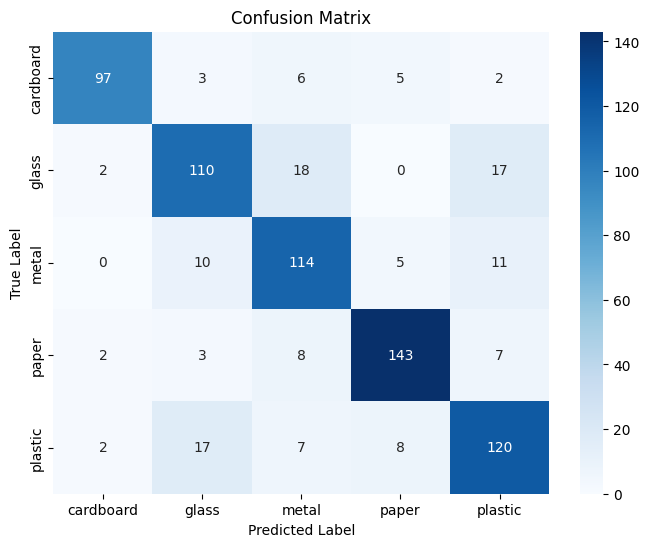


Test Metrics:
Accuracy: 0.8145 | Precision (Macro): 0.8217 | Recall (Macro): 0.8155 | F1 (Macro): 0.8179 | Precision (Micro): 0.8145 | Recall (Micro): 0.8145 | F1 (Micro): 0.8145

Test Per-Class Metrics:
Class 0: Precision: 0.9417 | Recall: 0.8584 | F1: 0.8981
Class 1: Precision: 0.7692 | Recall: 0.7483 | F1: 0.7586
Class 2: Precision: 0.7451 | Recall: 0.8143 | F1: 0.7782
Class 3: Precision: 0.8882 | Recall: 0.8773 | F1: 0.8827
Class 4: Precision: 0.7643 | Recall: 0.7792 | F1: 0.7717


In [ ]:
# Load the best model
model = trashnet(num_classes=num_classes).to(device)
model.load_state_dict(torch.load("best_trashnet_model.pth"))

# Evaluate on the test set
test_metrics = test_model(model, test_loader, device, num_classes)

The test results indicate an overall accuracy of 81.45%, with balanced macro and micro metrics, which means consistent performance across the dataset. The macro-averaged F1-score of 0.8179 highlights that the model performs reasonably well across all classes, regardless of class size, while the micro metrics, also at 0.8145, suggest robust overall performance dominated by the majority of predictions.

A closer look at per-class metrics reveals that Class 0 (cardboard) and Class 3 (paper) performed the best, achieving F1-scores of 89.81% and 88.27%, respectively, with minimal misclassifications. On the other hand, Class 1 (glass) struggled the most, with an F1-score of 75.86%, showing significant misclassifications into Class 2 (metal) and Class 4 (plastic), likely due to some similarities in visual features. Similarly, Class 4 (plastic) exhibited less moderate performance with an F1-score of 77.17%, showing confusion particularly with Class 1 (glass). Class 2 (metal) achieved a moderate performance too with an F1-score of 77.82% showing some overlap with misclassifications into Class 1 (glass) and Class 4 (plastic).

Overall, the model demonstrates strong generalization and solid performance, particularly for easily distinguishable classes, but further refinement in feature extraction is needed to improve the classification of visually similar materials such as glass, metal, and plastic.